In [1]:
import pandas as pd

colunas = ['PROCESSO', 'ROTULO_MANUAL', 'LEI']

df = pd.read_csv('../data/leis.csv', header=0, sep=',', quotechar='"', usecols=colunas)

In [2]:
 df.head()

,PROCESSO,ROTULO_MANUAL,LEI
0,00039604720138240039,CDC,9656/1998
1,00039604720138240039,CDC,616/2012
2,00039604720138240039,CDC,9656/1998
3,00039604720138240039,CDC,616/2012
4,00039604720138240039,CDC,9656/1998


Utitiza apenas label que contenham mais de 200 exemplos.

In [3]:
rotulos_ignorados = ['PRE', 'TIT', 'COM', 'DMI', 'FAM', 'OIE', 'AUT', 'SOC', 'SUC', 'RESCO', 'MAR', 'CIV', 'POS', 'INF', 'REG']

df.loc[df['ROTULO_MANUAL'].isin( rotulos_ignorados), 'ROTULO_MANUAL'] = 'NONE'

In [4]:
groupby_rotulo = df.groupby('ROTULO_MANUAL')

groupby_rotulo[['LEI']].count().sort_values(['LEI'], ascending=False)

,LEI
ROTULO_MANUAL,
EXP,905
SEG,803
OIG,694
BAN,654
NONE,546
BUS,334
FAL,261
CON,257
SFH,210


In [5]:
df.shape

(5197, 3)

In [6]:
data = df.groupby(['PROCESSO', 'ROTULO_MANUAL', 'LEI']).size().unstack('LEI', fill_value=0)
data = data.reset_index()

data.head()

LEI,PROCESSO,ROTULO_MANUAL,1/1975,1/2012,100/2015,101/2010,10144/2002,10150/2000,1025/2009,10257/2001,...,9610/1998,9611/1998,9612/1998,9615/1998,9656/1988,9656/1997,9656/1998,9658/1998,9800/1999,9870/1999
0,00000042920148240058,CON,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00000057320168240242,NONE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00000110319958240053,NONE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00000186020108240023,NONE,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
4,00000224520138240071,OIG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y = data['ROTULO_MANUAL'].values
y.shape

(1218,)

In [8]:
df1 = data.iloc[:,2:].copy()
df1.head()

LEI,1/1975,1/2012,100/2015,101/2010,10144/2002,10150/2000,1025/2009,10257/2001,104/1990,1060/1950,...,9610/1998,9611/1998,9612/1998,9615/1998,9656/1988,9656/1997,9656/1998,9658/1998,9800/1999,9870/1999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
x = df1.values
x.shape

(1218, 255)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

import collections

print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({'SEG': 151, 'OIG': 148, 'BAN': 124, 'NONE': 107, 'EXP': 85, 'CON': 61, 'BUS': 58, 'CDC': 39, 'SFH': 37, 'RAI': 34, 'DAN': 25, 'DPV': 23, 'FAL': 21})
Counter({'OIG': 50, 'SEG': 49, 'NONE': 46, 'BAN': 40, 'EXP': 23, 'BUS': 20, 'RAI': 14, 'CDC': 13, 'DPV': 12, 'CON': 12, 'SFH': 12, 'DAN': 8, 'FAL': 6})


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

text_clf = Pipeline([
    ('clf', clf)
])

text_clf.fit(x , y)

Pipeline(memory=None,
     steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

Testando o modelo.

In [23]:
y_pred = text_clf.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.8786885245901639

In [24]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         BAN       0.80      0.93      0.86        40
         BUS       0.85      0.85      0.85        20
         CDC       0.90      0.69      0.78        13
         CON       0.80      0.67      0.73        12
         DAN       0.83      0.62      0.71         8
         DPV       1.00      1.00      1.00        12
         EXP       0.96      0.96      0.96        23
         FAL       0.80      0.67      0.73         6
        NONE       0.84      0.78      0.81        46
         OIG       0.89      1.00      0.94        50
         RAI       0.67      0.57      0.62        14
         SEG       0.98      1.00      0.99        49
         SFH       0.92      0.92      0.92        12

   micro avg       0.88      0.88      0.88       305
   macro avg       0.86      0.82      0.84       305
weighted avg       0.88      0.88      0.88       305



In [25]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)

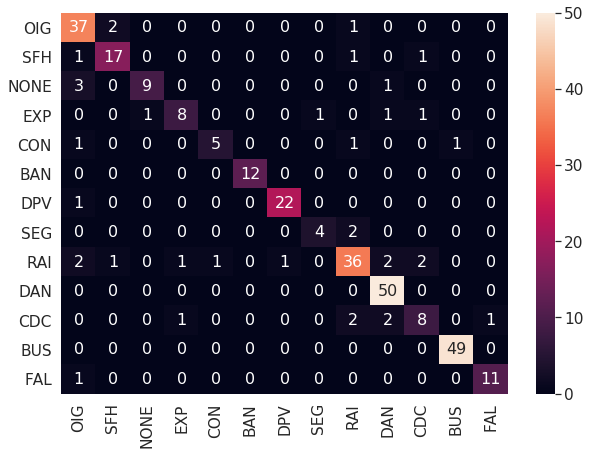

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = set(y_test)
      
df_cm = pd.DataFrame(cnf_matrix, range(13), range(13))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, xticklabels=labels, yticklabels=labels, annot=True,annot_kws={"size": 16})

In [27]:
features = list(data.columns.values)
del features[0:2]

len(features)

255

In [28]:
df_sample = pd.DataFrame(columns=features)
df_sample = df_sample.append({'9656/1998': 1}, ignore_index=True)
df_sample = df_sample.fillna(0)

df_sample

,1/1975,1/2012,100/2015,101/2010,10144/2002,10150/2000,1025/2009,10257/2001,104/1990,1060/1950,...,9610/1998,9611/1998,9612/1998,9615/1998,9656/1988,9656/1997,9656/1998,9658/1998,9800/1999,9870/1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
y_pred = text_clf.predict(df_sample)

y_pred

array(['CDC'], dtype=object)

In [30]:
from sklearn.externals import joblib

joblib.dump(features, '../modelos/Features-Leis.pkl', compress = 1)
joblib.dump(clf, '../modelos/Modelo-Leis.pkl', compress = 1) 

['../modelos/Modelo-Leis.pkl']